<a href="https://colab.research.google.com/github/Adil1999/Facial-Recognition-System/blob/master/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facial Recongnition with FaceNet

## loading dataset from drive


In [1]:
pip install pyDrive

In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
f1 = drive.CreateFile({'id': '1l6WMyFRT0E0IQ4Hj8fF24t0VKQYBtg-G'})
f1.GetContentFile("lfw.zip")
f2 = drive.CreateFile({'id': '1Ja9B3gJN1CcE8FetfaqK8gkengMQyIFD'})
f2.GetContentFile("lfw.csv")
f2 = drive.CreateFile({'id': '1G3skZ95RVdoRN-nWCKSiprDyY9O7RfEU'})
f2.GetContentFile("lfw_allnames.csv")

In [ ]:
!apt install unzip
!unzip lfw.zip

In [5]:
import csv
import random
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from skimage import io 


##Data Preprocessing

In [6]:
columns = ['id','name','class']
dataset = pd.read_csv('/content/lfw.csv')
print(dataset)

                            id                name  class
0                 AJ_Cook_0001             AJ_Cook      0
1                AJ_Lamas_0001            AJ_Lamas      1
2           Aaron_Eckhart_0001       Aaron_Eckhart      2
3             Aaron_Guiel_0001         Aaron_Guiel      3
4         Aaron_Patterson_0001     Aaron_Patterson      4
...                        ...                 ...    ...
13228      Zorica_Radovic_0001      Zorica_Radovic   5744
13229      Zulfiqar_Ahmed_0001      Zulfiqar_Ahmed   5745
13230        Zumrati_Juma_0001        Zumrati_Juma   5746
13231     Zurab_Tsereteli_0001     Zurab_Tsereteli   5747
13232  Zydrunas_Ilgauskas_0001  Zydrunas_Ilgauskas   5748

[13233 rows x 3 columns]


###Data Split

In [ ]:
def get_ids(df):
  names = dict()
  for i, ID in enumerate(df['class']):
      if ID not in names:
          names[ID] = []
      names[ID].append(df.iloc[i, 0])
  return names

indices = dataset['class'].unique()
Ids = get_ids(dataset)

def train_test_split(dataset, test_split = 0.2):
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  shuffle_dataset = True
  split = int(np.floor(test_split * dataset_size))
  random_seed= 42
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, test_indices = indices[split:], indices[:split]
  return train_indices, test_indices

train_indices, test_indices = train_test_split(Ids)

###Triplet Dataset

In [8]:
class ToTensor(object):
  def _call_(self, sample):
    image, label = sample['image'], sample['label']
    image = image.transpose((2, 0, 1))
    return {'image': torch.from_numpy(image),
            'label': torch.from_numpy(label)}

class triplet_dataset(torch.utils.data.DataLoader):
  def __init__(self, root_dir=  "/content/lfw/", transform = None, train=0):
    # train 0 = triplet return
    # train 1 = train images return
    # train 2 = test images return 

    self.csv_dir = "/content/lfw_allnames.csv"
    self.train = train
    self.root_dir = root_dir
    self.transform = transform
    self.train_dataset,self.test_dataset = self.get_data_set()
    temp = self.train_dataset.groupby(['name']).image_path.apply(lambda x: list(x.values)).reset_index()
    print(temp.head())
    self.training_triplets = self.make_triplets(temp['name'], temp['image_path'], temp.index)
  
  def get_data_set(self,):
    train_set = pd.read_csv(self.csv_dir)
    train_set = train_set.loc[train_set.index.repeat(train_set['images'])]
    train_set['image_path'] = 1 + train_set.groupby('name').cumcount()
    train_set['image_path'] = train_set.image_path.apply(lambda x: '{0:0>4}'.format(x))
    train_set['image_path'] = train_set.name + "/" + train_set.name + "_" + train_set.image_path + ".jpg"
    train_set['label'] = train_set.index
    temp = train_set.where(train_set['images'] >= 2).dropna()

    random_class = random.sample(range(temp.index[0], temp.index[-1]), 10)
    test_set = pd.DataFrame(columns= train_set.columns)
    for i in random_class:
      index = temp.index[i]
      x = temp[temp.label == index]
      x = x.dropna()
      test_set = test_set.append(x, ignore_index = True)
      
    train_set = pd.merge(train_set,test_set, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
    train_set = train_set.drop(['images'], axis= 1)
    test_set = test_set.drop(['images'], axis= 1)
    test_set = test_set.reset_index().drop(['index'], axis= 1) 
    train_set.drop(['label'],axis= 1)
    return train_set,test_set
  
  def make_triplets(self, names, Ids, classes):
    print(names[5],Ids[5],classes[5])
    
    triplet_size = len(classes)
    triplets = []
    for i in range(triplet_size):
      #selecting anchor image and positive image
      pos_index = np.random.choice(classes)
      #print(type(pos_index), pos_index)
      while len(Ids[pos_index]) < 2:
          pos_index = np.random.choice(classes)
      anchor = np.random.randint(0, len(Ids[pos_index]))
      postive = np.random.randint(0, len(Ids[pos_index]))
      while anchor == postive:
          postive = np.random.randint(0, len(Ids[pos_index]))
      
      
      #selecting negative image
      neg_index = np.random.choice(classes)
      while pos_index == neg_index:
          neg_index = np.random.choice(classes)
      negative = np.random.randint(0, len(Ids[neg_index]))
      
      postive_class = names[pos_index]
      negative_class = names[neg_index]
      
      triplets.append([Ids[pos_index][anchor], Ids[pos_index][postive], 
                         Ids[neg_index][negative], postive_class, negative_class, pos_index, neg_index])
    return triplets
  
  #train_set = make_triplets('/content/lfw', Ids, train_indices)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    if(self.train == 0):    
      anc_id, pos_id, neg_id, positive_class, negative_class, pos_index, neg_index = self.training_triplets[idx]
      #print(type(anc_id),type(pos_id),type(neg_id))
      anc_img   = os.path.join(self.root_dir, anc_id)
      pos_img   = os.path.join(self.root_dir, pos_id)
      neg_img   = os.path.join(self.root_dir, neg_id)

      anc_img   = io.imread(anc_img)
      pos_img   = io.imread(pos_img)
      neg_img   = io.imread(neg_img)
      
      pos_class = torch.from_numpy(np.array([pos_index]).astype('long'))
      neg_class = torch.from_numpy(np.array([neg_index]).astype('long'))
      
      sample = {'ancher': anc_img, 'postive': pos_img, 'negative': neg_img, 
                'postive_label': positive_class, 'negative_label': negative_class}

      if self.transform:
        sample['ancher'] = self.transform(sample['ancher'])
        sample['postive'] = self.transform(sample['postive'])
        sample['negative'] = self.transform(sample['negative'])

    elif(self.train == 1): #for train_Set images
      anc_img   = os.path.join(self.root_dir, self.train_dataset.iloc[idx]['image_path'])
      img   = io.imread(anc_img)
      klass = self.train_dataset.iloc[idx]['name']
      sample = {'img': img, 'class': klass}
      if self.transform:
          sample['img'] = self.transform(sample['img'])
    
    else:  #for test_Set images
      anc_img   = os.path.join(self.root_dir, self.test_dataset.iloc[idx]['image_path'])
      img   = io.imread(anc_img)
      klass = self.test_dataset.iloc[idx]['name']
      sample = {'img': img, 'class': klass}
      if self.transform:
          sample['img'] = self.transform(sample['img'])

    return sample
  
  def __len__(self):
    if(self.train == 0):
      return len(self.training_triplets)
    elif(self.train == 1):
      return len(self.train_dataset)
    else:
      return len(self.test_dataset)

In [9]:
def get_data_loaders(batchSize=8, numWorker=4, train=0): 
  data_transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize([220,220]),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])
  dataset = triplet_dataset(transform = data_transforms, train = train)
  dataloaders = torch.utils.data.DataLoader(dataset, batch_size = batchSize, shuffle = False, num_workers = numWorker)
  return dataset,dataloaders

In [10]:
dataset,train_loader = get_data_loaders(batchSize=64, train=0)
print(len(train_loader))
print(len(dataset))

              name                                  image_path
0          AJ_Cook                  [AJ_Cook/AJ_Cook_0001.jpg]
1         AJ_Lamas                [AJ_Lamas/AJ_Lamas_0001.jpg]
2    Aaron_Eckhart      [Aaron_Eckhart/Aaron_Eckhart_0001.jpg]
3      Aaron_Guiel          [Aaron_Guiel/Aaron_Guiel_0001.jpg]
4  Aaron_Patterson  [Aaron_Patterson/Aaron_Patterson_0001.jpg]
Aaron_Peirsol ['Aaron_Peirsol/Aaron_Peirsol_0001.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0003.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0004.jpg'] 5
90
5739


###Random Sample from Triplet Data

3 ['Carolina_Kluft', 'Ernesto_Zedillo', 'Russell_Simmons', 'Patricia_Heaton', 'Ilan_Ramon', 'Gregory_Geoffroy', 'Alex_Sink', 'Al_Pacino', 'Jim_Furyk', 'Roh_Moo-hyun', 'Tom_Watson', 'John_Stallworth', 'Hassan_Nasrallah', 'Clay_Aiken', 'Tim_Curry', 'George_Voinovich', 'Yoriko_Kawaguchi', 'Andrew_Weissmann', 'Tomoko_Hagiwara', 'Judi_Dench', 'Chuck_Yeager', 'Lucy_Liu', 'Tim_Robbins', 'Rick_Romley', 'Gregory_Geoffroy', 'Yao_Ming', 'Mark_Hurlbert', 'Tassos_Papadopoulos', 'Kenneth_Evans', 'Michael_Leavitt', 'Ben_Affleck', 'George_Brumley', 'Fred_Eckhard', 'Matt_Doherty', 'Debra_Brown', 'Gustavo_Kuerten', 'George_Papandreou', 'Justin_Leonard', 'Patricia_Clarkson', 'Sheryl_Crow', 'Edward_James_Olmos', 'Andy_Roddick', 'Sergio_Garcia', 'Patty_Schnyder', 'Akbar_Hashemi_Rafsanjani', 'Cameron_Diaz', 'Benazir_Bhutto', 'Holly_Hunter', 'Blythe_Hartley', 'Angela_Merkel', 'Paul_Martin', 'Stanley_McChrystal', 'Halle_Berry', 'Charles_Bronson', 'Geraldine_Chaplin', 'Oprah_Winfrey', 'Claire_Hentzen', 'Prince

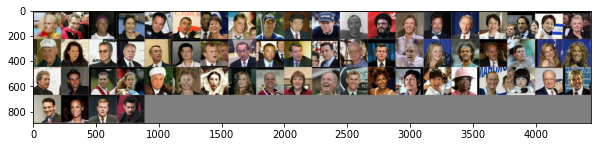

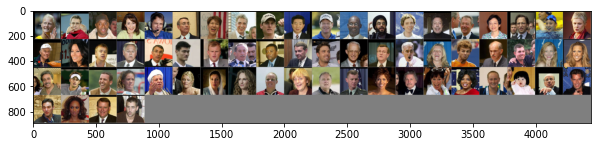

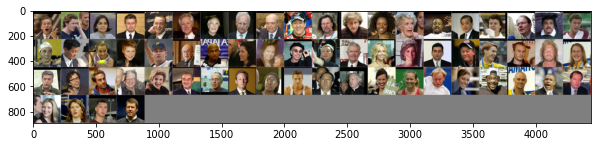

In [11]:
def showImg(image):
  image = image/2 + 0.5
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(image,(1,2,0)))

for i, batch in enumerate(train_loader):
  #print(i, batch['postive_label'], batch['postive'].size())

  if i == 3:
    print(i, batch['postive_label'], batch['postive'].size())
    showImg(torchvision.utils.make_grid(batch['ancher'], nrow=20))
    showImg(torchvision.utils.make_grid(batch['postive'], nrow=20))
    showImg(torchvision.utils.make_grid(batch['negative'], nrow=20))
    break

##Training Data

In [ ]:
from torch.autograd import Variable,Function
from torch.nn.modules.distance import PairwiseDistance

###Triplet Loss Function

In [ ]:
def triplet_loss(anchor, positive, negative, margin= 0.2):
    dist_pos = (anchor - positive).pow(2).sum(1)
    dist_neg = (anchor - negative).pow(2).sum(1)
    loss = F.relu(dist_pos - dist_neg + margin)
    loss = loss.mean()
    return loss

###Siamese NN

In [ ]:
class FaceNetSiameseNetwork(nn.Module):
  def __init__(self):
    super(FaceNetSiameseNetwork, self).__init__()
    self.convnn = nn.Sequential(
        nn.Conv2d(3, 64, 7, stride=2, padding=3),
        nn.MaxPool2d(3, 2,padding=1),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, 1, stride=1, padding=0),
        nn.Conv2d(64, 192, 3, stride=1, padding=1),
        nn.BatchNorm2d(192),
        nn.MaxPool2d(3, 2,padding=1),
        nn.Conv2d(192, 192, 1, stride=1, padding=0),
        nn.Conv2d(192, 384, 3, stride=1, padding=1),
        nn.MaxPool2d(3, 2,padding=1),
        nn.Conv2d(384, 384, 1, stride=1, padding=0),
        nn.Conv2d(384, 256, 3, stride=1, padding=1),
        nn.Conv2d(256, 256, 1, stride=1, padding=0),
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.Conv2d(256, 256, 1, stride=1, padding=0),
        nn.Conv2d(256, 256, 3, stride=1, padding=1),
        nn.MaxPool2d(3, 2,padding=1),
        )

    self.fcnn1 = nn.Sequential( 
        nn.Linear(7*7*256, 128),
        nn.Linear(128, 128),
        nn.Linear(128, 128),
        )
  

  def forward_on_one_datapt(self, datapt):
    output = self.convnn(datapt)
    output = output.view(output.size()[0], -1)
    output = self.fcnn1(output)
    output = output.view(output.size()[0], -1)
    output = F.normalize(output)
    return output

  def forward(self, a_img):
    output1 = self.forward_on_one_datapt(a_img)

    return output1
    

###Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = FaceNetSiameseNetwork()
net = net.float()
net = net.to(device)
optimizer = optim.Adam(net.parameters(),lr = 0.00005 )
train_loader.train = 0
#training
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(15):
  for i, batch in enumerate(train_loader):
    anc_img,pos_img,neg_img,label1,label2= batch['ancher'],batch['postive'],batch['negative'],batch['postive_label'],batch['negative_label']
    anc_img = anc_img.to(device)
    pos_img = pos_img.to(device)
    neg_img = neg_img.to(device)
    out1 = net(anc_img)
    out2 = net(pos_img)
    out3 = net(neg_img)
    optimizer.zero_grad()
    loss_triplet = triplet_loss(out1,out2,out3)
    loss_triplet.backward()
    optimizer.step()
    if(iteration_number % 10 == 0):
      loss_history.append([iteration_number,loss_triplet])
    iteration_number +=1
  if loss_triplet <= 0.001:
      break
  print ("Cost after epoch %i: %f" % (epoch + 1, loss_triplet))


cuda:0
Cost after epoch 1: 0.125856
Cost after epoch 2: 0.073302
Cost after epoch 3: 0.054886
Cost after epoch 4: 0.056155
Cost after epoch 5: 0.045672
Cost after epoch 6: 0.028371
Cost after epoch 7: 0.012793
Cost after epoch 8: 0.012364
Cost after epoch 9: 0.017510
Cost after epoch 10: 0.003979
Cost after epoch 11: 0.010380
Cost after epoch 12: 0.004547
Cost after epoch 13: 0.007262
Cost after epoch 14: 0.001675
Cost after epoch 15: 0.001901


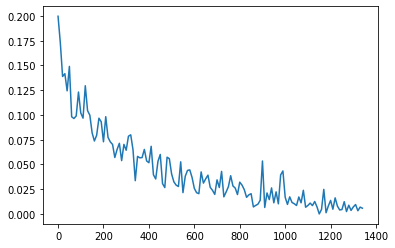

In [ ]:
X = np.array([i for i,j in loss_history])
Y = np.array([j.cpu().detach().numpy() for i,j in loss_history])
plt.plot(X,Y)

###Save Model

In [ ]:
torch.save(net.state_dict(), "/content/faceNet.pth")

In [ ]:
test_set,test_loaders  = get_data_loaders(train=2)

              name                                  image_path
0          AJ_Cook                  [AJ_Cook/AJ_Cook_0001.jpg]
1         AJ_Lamas                [AJ_Lamas/AJ_Lamas_0001.jpg]
2    Aaron_Eckhart      [Aaron_Eckhart/Aaron_Eckhart_0001.jpg]
3      Aaron_Guiel          [Aaron_Guiel/Aaron_Guiel_0001.jpg]
4  Aaron_Patterson  [Aaron_Patterson/Aaron_Patterson_0001.jpg]
Aaron_Peirsol ['Aaron_Peirsol/Aaron_Peirsol_0001.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0003.jpg', 'Aaron_Peirsol/Aaron_Peirsol_0004.jpg'] 5


In [ ]:
#after model is saved assign that data to variable enc (128 size)
images = [] # enconding
labels = [] 
for i_batch, sample_batched in enumerate(test_loaders):
  img, lbl = sample_batched['img'], sample_batched['class']
  trained_img = net(img.to(device))
  images.append(trained_img.cpu().detach().numpy())
  labels.append(lbl)

imgs_flatten = []
labels_flatten = []
for i in range(len(images)): #total  batches
  for j in range(len(labels[i])): #batch size
    imgs_flatten.append(images[i][j])
    labels_flatten.append(labels[i][j])

images = imgs_flatten
labels = labels_flatten    

test_set = pd.DataFrame(list(zip(labels,images)), columns= ["Name","model"]) 
test_set = test_set.groupby(['Name']).model.apply(lambda x: list(x.values)).reset_index()

In [ ]:
def train_test_split(test_set, split_size=0.8):
  Xtrain = []; Xtest = []; Ytrain = []; Ytest = []

  for i in range(test_set.shape[0]):
    from_model = test_set.iloc[i]['model']
    label = test_set.iloc[i]['Name']
    from_model_len = len(from_model)
    for j in range(from_model_len):
      if j <= int (from_model_len * split_size):
        Xtrain.append(from_model[j])
        Ytrain.append(label)
      else:
        Xtest.append(from_model[j])
        Ytest.append(label)
    
  return np.array(Xtrain),np.array(Xtest),np.array(Ytrain),np.array(Ytest)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(test_set)
print(Xtrain.shape, Ytrain.shape,Xtest.shape,Ytest.shape)

(344, 128) (344,) (80, 128) (80,)


##Building A Classifier (KNN)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances 
import scipy.stats as ss

class KNN:
    def __init__(self, k, scalefeatures=False):
        self.K=k

    def train(self, X, Y):
        self.X_train=X
        self.Y_train=Y

    def predict(self, X):
        num_test = X.shape[0]
        y_pred = np.zeros(self.K, dtype = self.Y_train.dtype)
        pclass=[]
        compute_distance = euclidean_distances(X, self.X_train)  
        for x in range(num_test):
            dist = np.sort(compute_distance[x])
            for y in range(self.K):
                index = np.where(dist[y] == compute_distance[x])
                y_pred[y] = self.Y_train[index][0]
            pclass.append(ss.mode(y_pred)[0][0])
        return np.array(pclass)

In [ ]:
#classifier
clf = KNN(k=3)
clf.train(Xtrain, Ytrain)
y_pred = clf.predict(Xtest)
#print("KNN Classification accuracy", clf.accuracy(Ytest, y_pred))

### Accuracy

In [ ]:
total= Ytest.shape[0]
correct = 0
for i in range(len(Ytest)):
  if y_pred[i] == Ytest[i]:
    correct += 1
print("Accuracy is : ", (correct/total) * 100)

Accuracy is :  75.0
